In [3]:
import yfinance as yf
import edgar
import requests
import time
import pandas as pd
import polars as pl
import polars.selectors as cs
from polars import functions as pf
import math
import os
import re
import urllib.parse
from datetime import datetime
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

In [1]:
COMPANY_NAME_LIST = ['Apple%2520Inc.%2520(AAPL)%2520(CIK%25200000320193)', 'MICROSOFT%2520CORP%2520(MSFT)%2520(CIK%25200000789019)', 
                     'BigCommerce%2520Holdings%252C%2520Inc.%2520(BIGC)%2520(CIK%25200001626450)', 'ROKU%252C%2520INC%2520(ROKU)%2520(CIK%25200001428439)', 
                     'JPMORGAN%2520CHASE%2520%2526%2520CO%2520(JPM%252C%2520AMJ%252C%2520AMJB%252C%2520JPM)%2520(CIK%25200000019617)', 'VISA%2520INC.%2520(V)%2520(CIK%25200001403161)', 
                     'Block%252C%2520Inc.%2520(SQ%252C%2520BSQKZ)%2520(CIK%25200001512673)', 'Robinhood%2520Markets%252C%2520Inc.%2520(HOOD)%2520(CIK%25200001783879)', 
                     'JOHNSON%252C%252C%2520JOHNSON%2520(JNJ)%2520(CIK%25200000200406)', 'PFIZER%2520INC%2520(PFE)%2520(CIK%25200000078003)', 
                     'Moderna%252C%2520Inc.%2520(MRNA)%2520(CIK%25200001682852)', 'Teladoc%2520Health%252C%2520Inc.%2520(TDOC)%2520(CIK%25200001477449)', 
                     'EXXON%2520MOBIL%2520CORP%2520(XOM)%2520(CIK%25200000034088)', 'CHEVRON%2520CORP%2520(CVX)%2520(CIK%25200000093410)', 
                     'FIRST%2520SOLAR%252C%2520INC.%2520(FSLR)%2520(CIK%25200001274494)', 'PLUG%2520POWER%2520INC%2520(PLUG)%2520(CIK%25200001093691)', 
                     'GENERAL%252CELECTRIC%2520CO%2520(GE)%2520(CIK%25200000040545)', '3M%2520CO%2520(MMM)%2520(CIK%25200000066740)', 
                     'CATERPILLAR%2520INC%2520(CAT)%2520(CIK%25200000018230)', 'FASTENAL%2520CO%2520(FAST)%2520(CIK%25200000815556)']

In [19]:
df_dict_scores = {}
regex = r"\\([^\\]+)_full_doc_sen_score_df\.parquet$"

for root, dirs, files in os.walk(r'C:\Users\310\Desktop\Progects_Py\Parsim-sec\src\Analysis\data\full_10_Q_scores'):
    for file in files:
            
            file_path = os.path.join(root, file)
            ticker = re.search(regex, file_path).group(1)
            
            df = pl.read_parquet(file_path)

            df_dict_scores[ticker] = df 

In [20]:
df_dict_scores["AAPL"]

2019-05-01,2019-07-31,2019-10-31,2020-01-29,2020-05-01,2020-07-31,2020-10-30,2021-01-28,2021-04-29,2021-07-28,2021-10-29,2022-01-28,2022-04-29,2022-07-29,2022-10-28,2023-02-03,2023-05-05,2023-08-04,2023-11-03,2024-02-02
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
-20.273802,-20.195755,-23.054376,-4.905228,-5.471998,-4.878701,-23.414999,-4.229141,-4.244643,-4.473937,-24.155491,-1.515674,-1.572909,-1.710278,-23.229075,-1.802875,-1.688247,-1.783351,-23.56241,-3.121427
-130.0,-130.0,-139.0,-36.0,-39.0,-39.0,-145.0,-32.0,-33.0,-34.0,-148.0,-21.0,-20.0,-20.0,-145.0,-23.0,-20.0,-19.0,-149.0,-35.0
-0.485327,-0.485261,-0.388582,-0.323077,-0.355049,-0.357143,-0.399478,-0.338521,-0.312977,-0.277372,-0.410188,-0.304348,-0.269841,-0.333333,-0.401647,-0.365854,-0.316239,-0.268293,-0.403614,-0.405405
0.481886,0.484932,0.498635,0.568976,0.547017,0.575356,0.50845,0.587156,0.572391,0.577933,0.505206,0.607362,0.569444,0.556355,0.502616,0.605392,0.572979,0.540284,0.502885,0.585132


This is a func that takes as an input a key-value pair from df_dict_scores and calculate 4-days returns for it as a polars df with col names - dates of starting of 4-day period and col values (only one in each) - returns

In [7]:
def computing_returns(tic_sym, df):

    company_ticker = yf.Ticker(tic_sym)
    hist = company_ticker.history(period="5y")
    
    four_day_returns = {}

    for date_str in df.columns:

        date = pd.Timestamp(date_str, tz='America/New_York')

        while date not in hist.index:

            date += pd.Timedelta(days=1)

        start_index = hist.index.get_loc(date)

        start_price = hist.iloc[start_index]['Open']
        end_price = hist.iloc[start_index + 4]['Open']

        four_day_return = (end_price - start_price) / start_price * 100
        four_day_returns[date_str] = four_day_return

    four_day_returns_df = pl.DataFrame(four_day_returns)

    return four_day_returns_df


This is the general loop, that takes each key-value pair from df_dict_scores, applies computing_returns() to it, then verticaly stackes the result with orig df and stores it in the new dict

In [8]:
dict_for_anal = {}
row_names = pl.Series("row_names", ["weighted scores", "raw scores", "returns"])

for tic_sym, df in df_dict_scores.items():

    returns_df = computing_returns(tic_sym, df)
    
    stacked_df = df.vstack(returns_df)
    stacked_df_with_indx = stacked_df.hstack([row_names])
    
    dict_for_anal[tic_sym] = stacked_df_with_indx
    

In [9]:
dict_for_anal

{'AAPL': shape: (3, 16)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ 2019-05-0 ┆ 2019-07-3 ┆ 2020-01-2 ┆ 2020-05-0 ┆ … ┆ 2023-05-0 ┆ 2023-08-0 ┆ 2024-02-0 ┆ row_name │
 │ 1         ┆ 1         ┆ 9         ┆ 1         ┆   ┆ 5         ┆ 4         ┆ 2         ┆ s        │
 │ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │ f64       ┆ f64       ┆ f64       ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ str      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ -27.26905 ┆ -27.26302 ┆ -8.944616 ┆ -9.864765 ┆ … ┆ -2.244062 ┆ -2.351985 ┆ -4.427726 ┆ weighted │
 │ 5         ┆ 8         ┆           ┆           ┆   ┆           ┆           ┆           ┆ scores   │
 │ -129.0    ┆ -130.0    ┆ -36.0     ┆ -39.0     ┆ … ┆ -20.0     ┆ -19.0     ┆ -35.0     ┆ raw      │
 │           ┆           ┆           ┆           ┆   ┆    

Lets start the analisys. The general question is: how wel sentiment scores and weighted scores can explain returns? 

Lets see them on the graph:

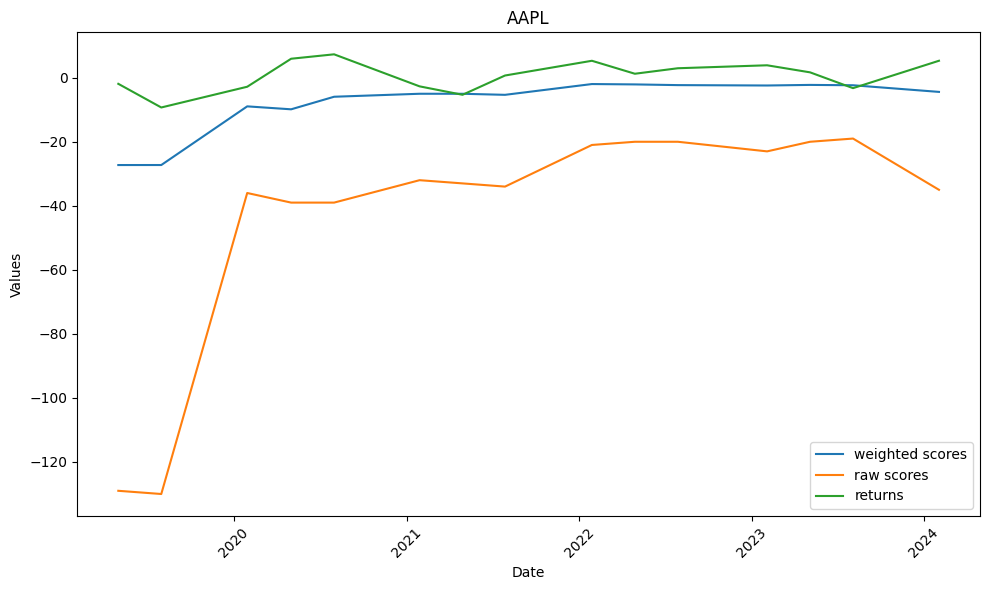

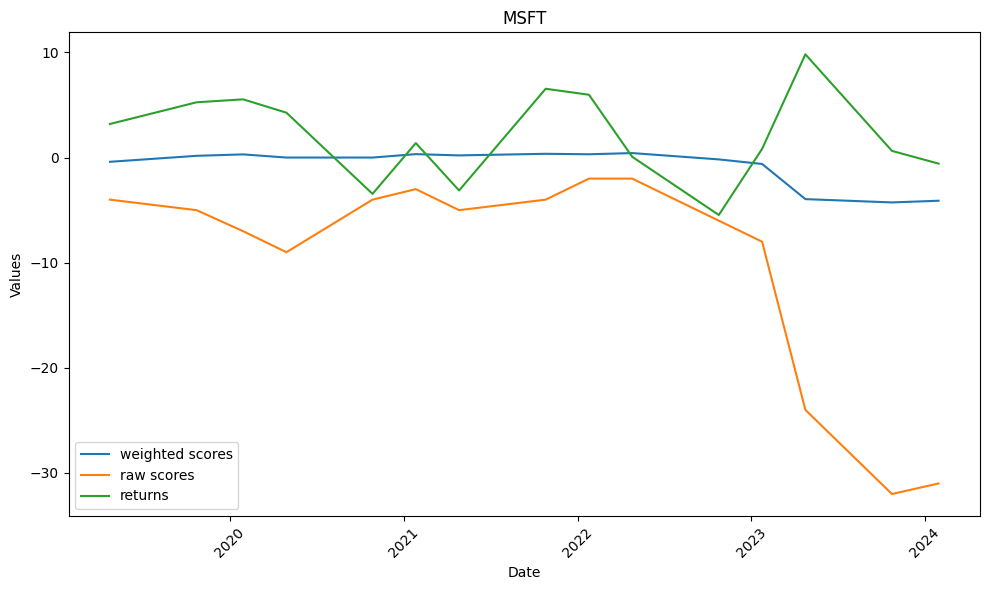

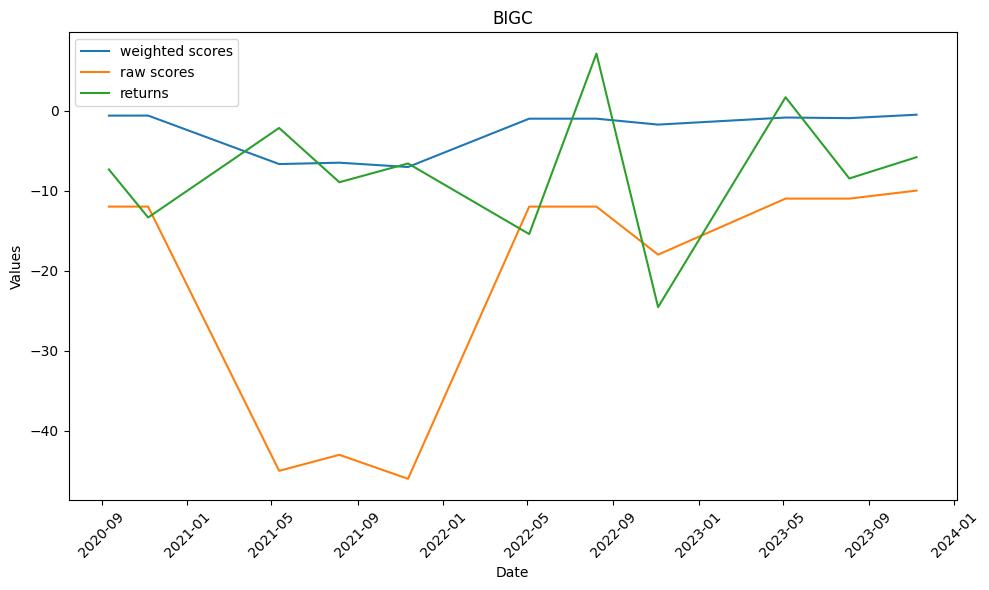

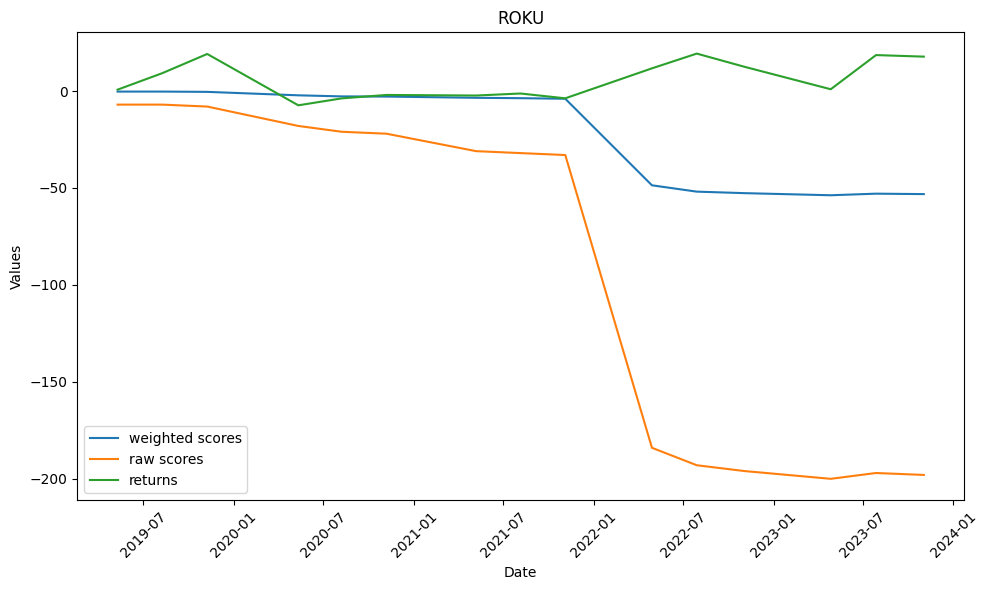

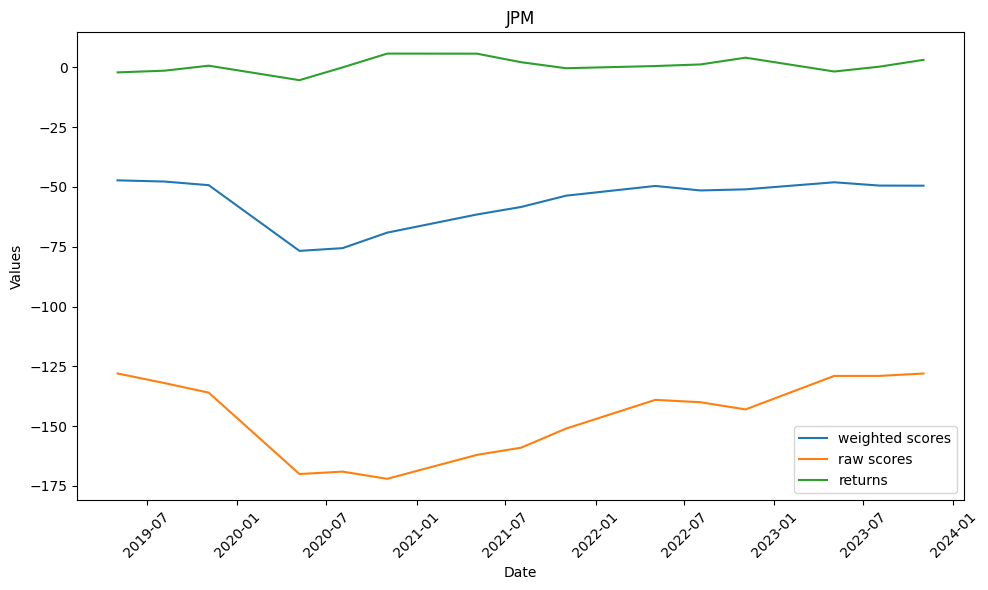

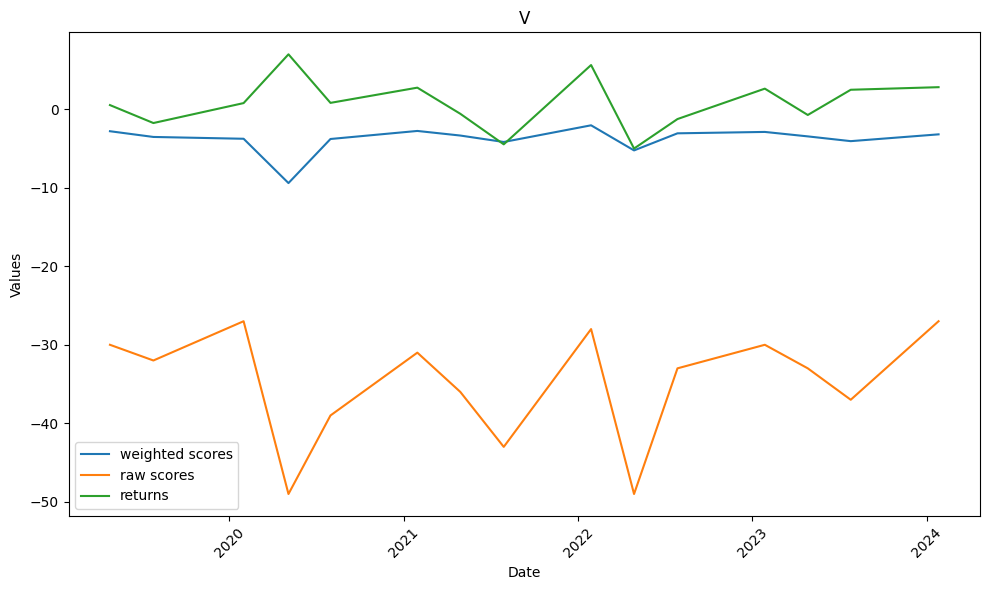

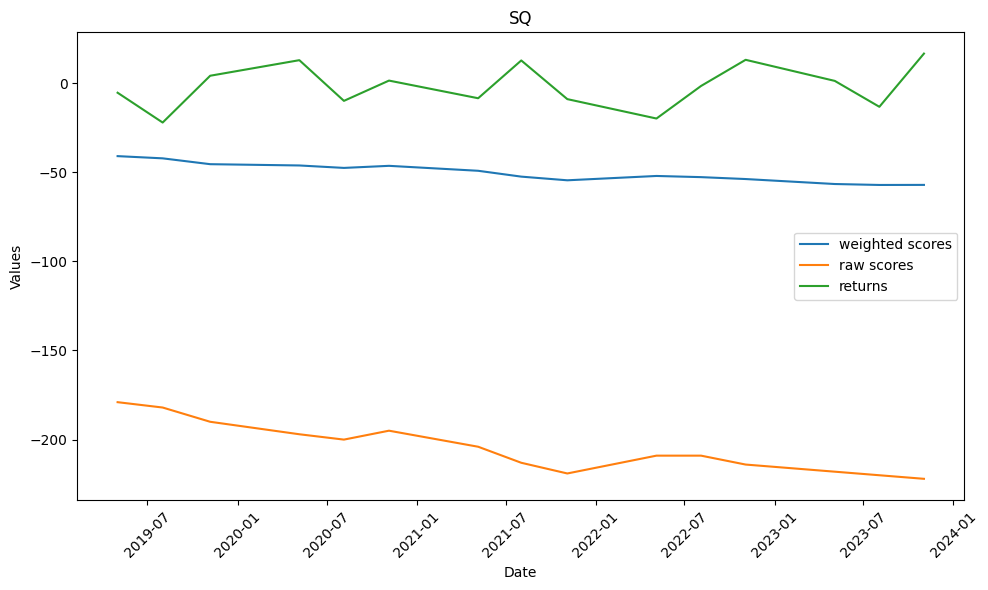

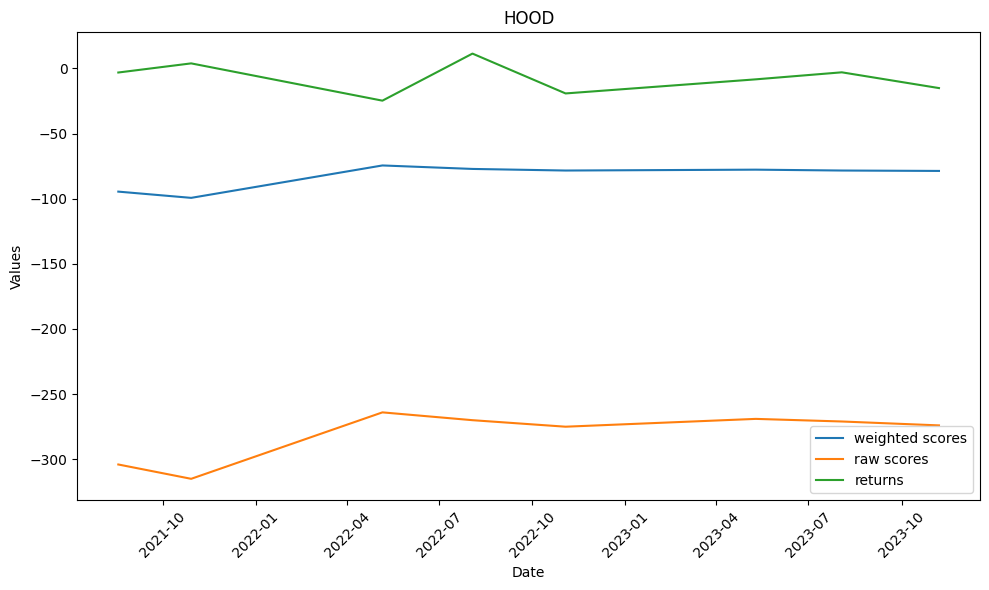

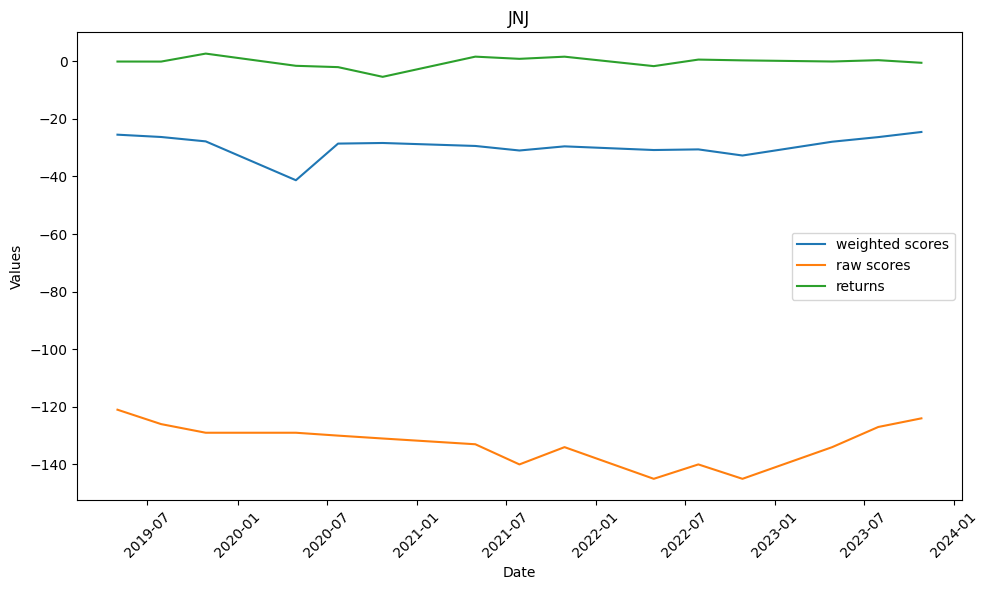

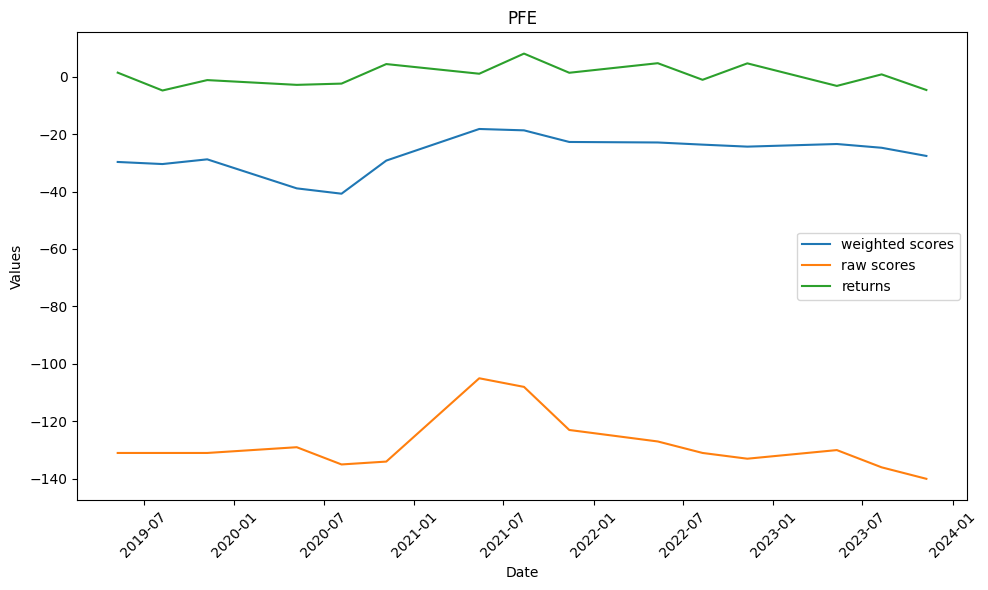

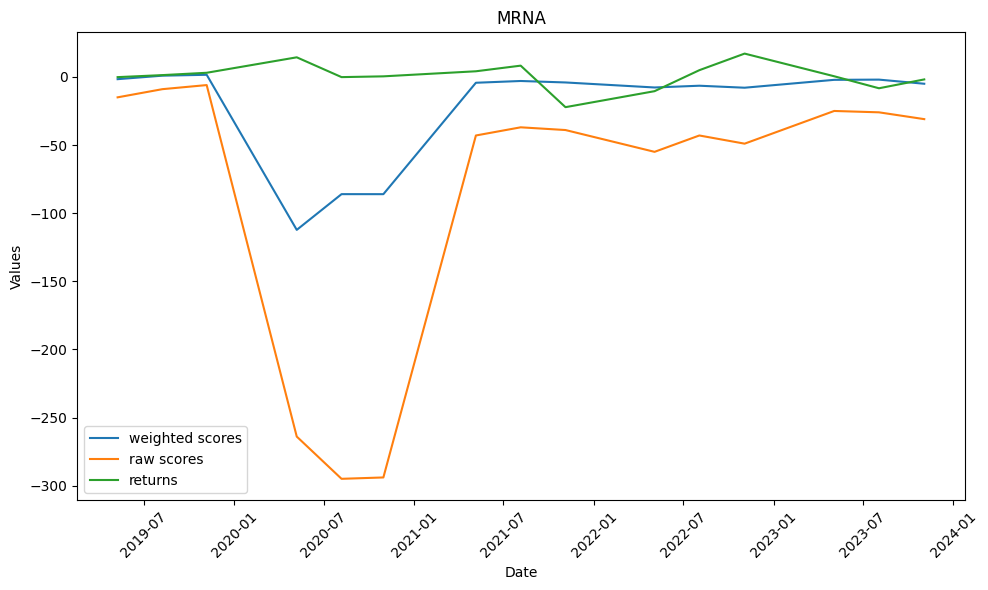

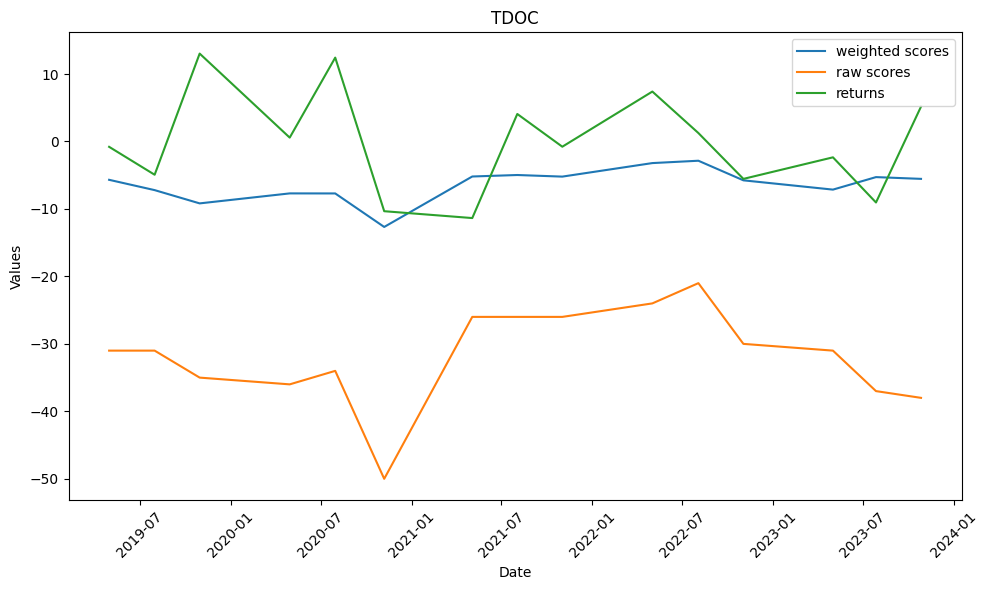

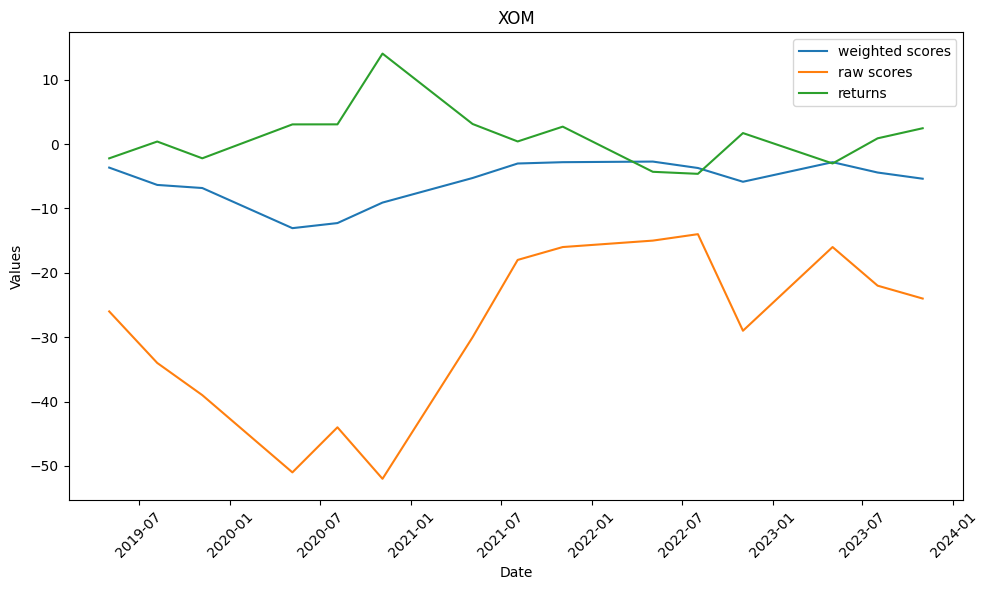

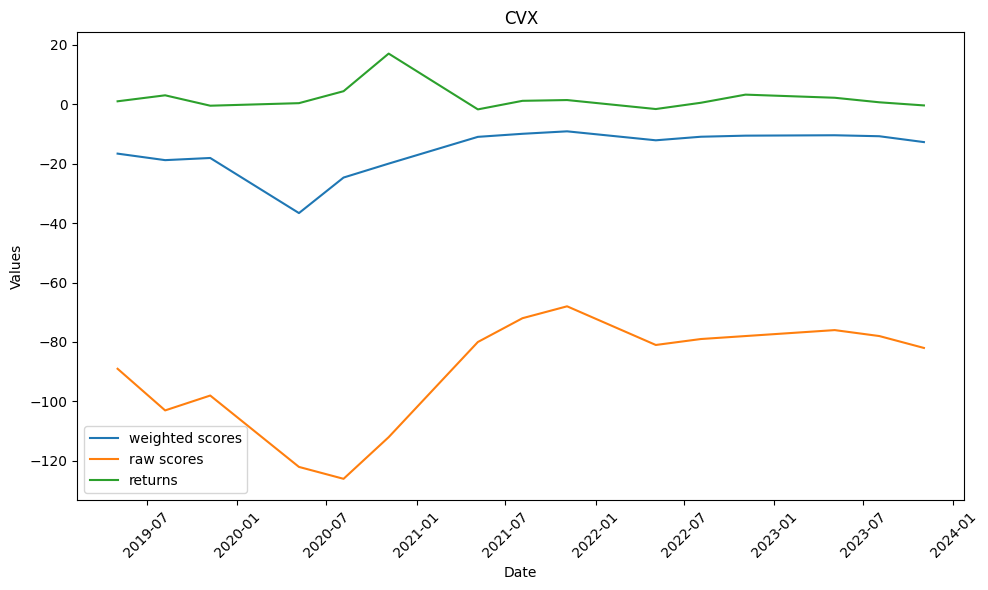

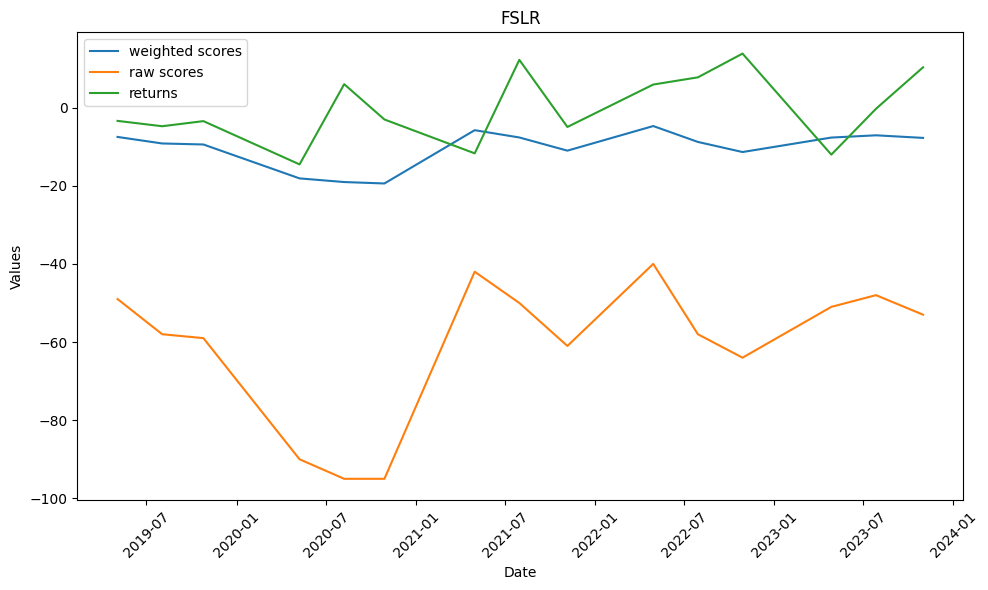

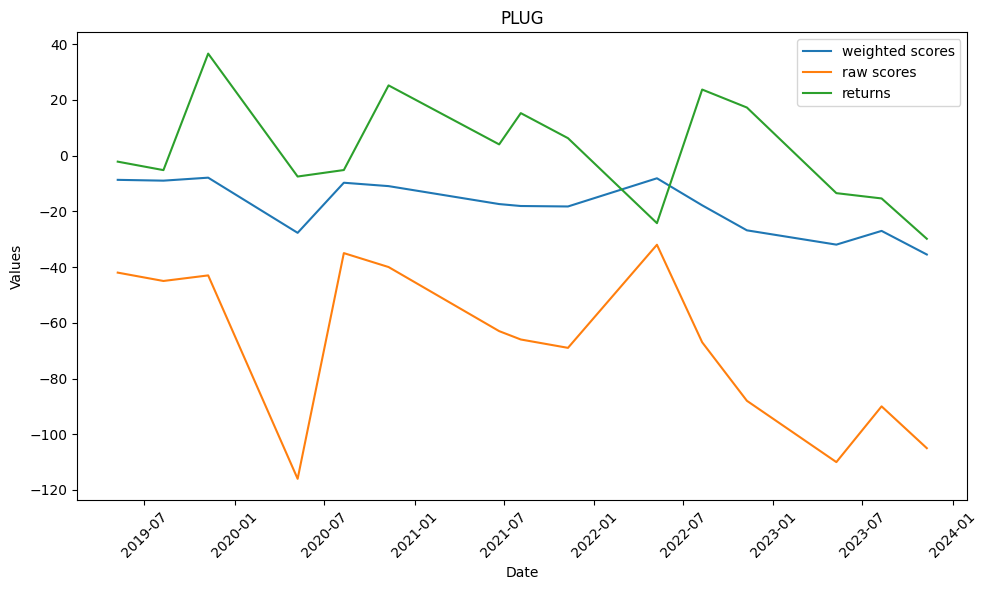

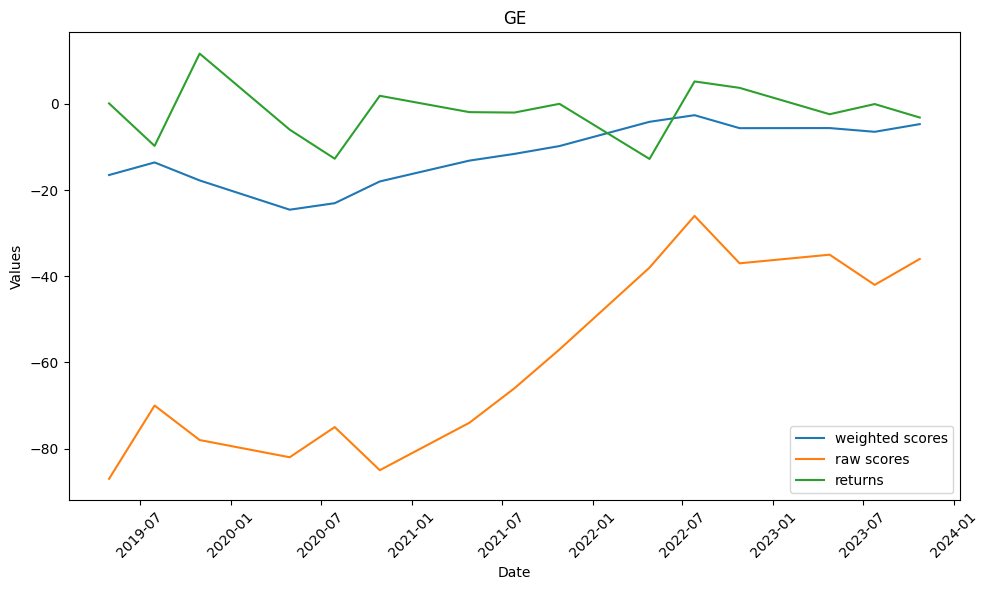

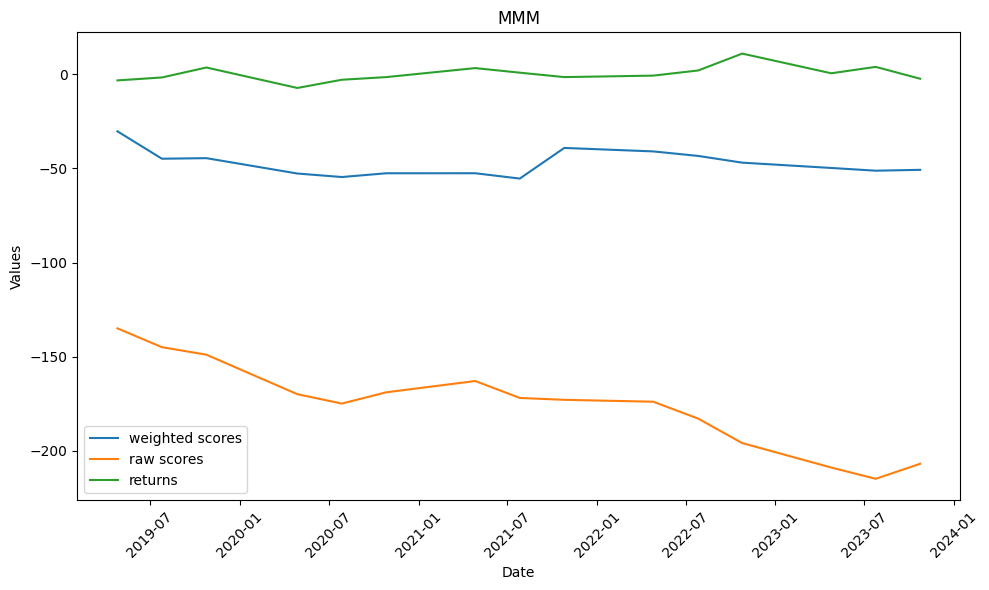

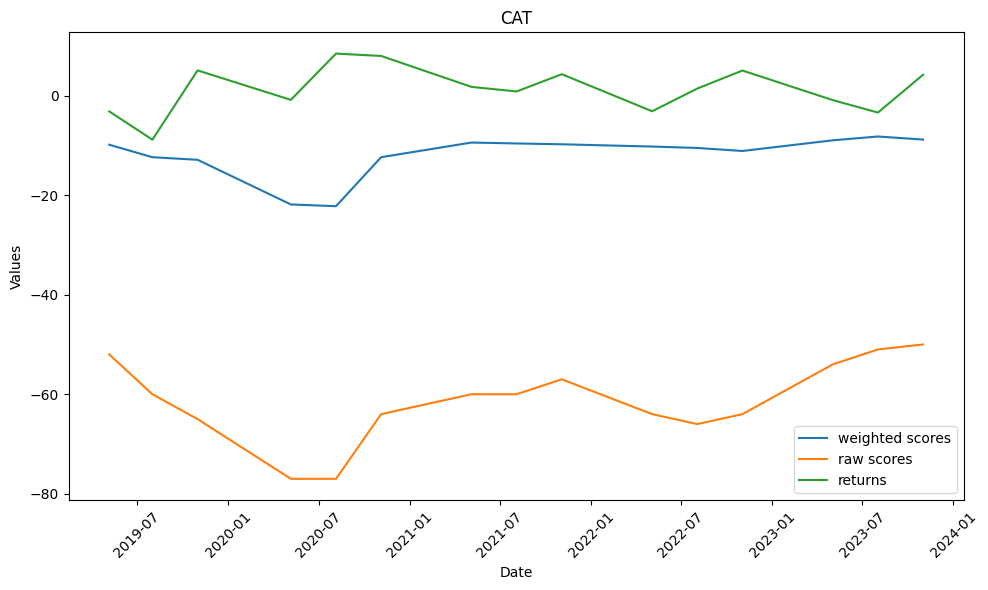

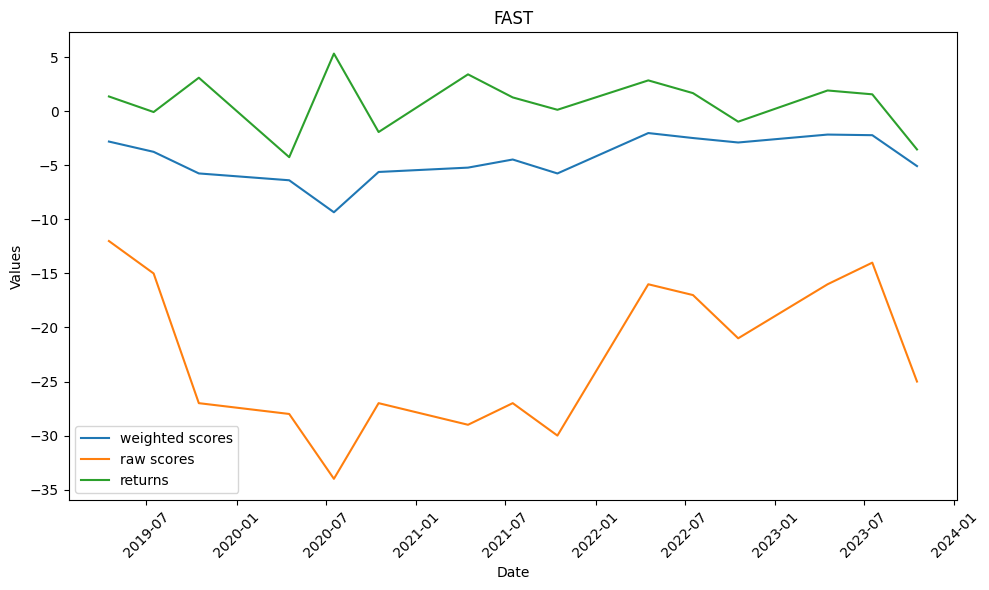

In [168]:
for company_name, scores in dict_for_anal.items():
   
    df_for_plt = scores.select(pl.exclude("row_names"))

    dates = [datetime.strptime(date, "%Y-%m-%d") for date in df_for_plt.columns]
   
    plt.figure(figsize=(10, 6))

    for idx, row in enumerate(df_for_plt.to_dicts()):
    
        plt.plot(dates, list(row.values()), label=df_msft.row(idx)[-1])

    plt.title(company_name)
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

At first glance some time series exhibits at least piecewise dependence. 

Next step is to regress each return on weighted and raw scores.

In [11]:
company_df = dict_for_anal["JPM"]
company_name = "JPM"

In [18]:
def regression_slopes(company_df, company_name):

    # x_1 - weighted score
    # x_2 - raw score
    company_df_woi = company_df.select(pl.exclude("row_names"))
    x_1 = company_df_woi.row(0)
    x_2 = company_df_woi.row(1)
    y = company_df_woi.row(2)


    x_1 = sm.add_constant(x_1)
    x_2 = sm.add_constant(x_2)

    model_1 = sm.OLS(y, x_1).fit()
    model_2 = sm.OLS(y, x_2).fit()

    #print(f'Model with weighted scores{model_1.summary()}')
    #print(f'Model with raw scores {model_2.summary()}')
    weighted_slope = model_1.params[1]
    raw_slope = model_2.params[1]
    summary_series = pl.Series(company_name, [weighted_slope, raw_slope])
    return summary_series

In [65]:
def compute_all_slopes(dict_for_anal):

    slopes_df = pl.DataFrame()
    for company_name, company_df in dict_for_anal.items(): 
        out_put_series = regression_slopes(company_df, company_name)
        slopes_df = slopes_df.hstack([out_put_series])
    return slopes_df
        

In [66]:
def calc_efficiency_metrics(dict_for_anal):
    all_slopes_4_days = compute_all_slopes(dict_for_anal)

    floats_series_w = pl.Series(all_slopes_4_days.row(0))
    floats_series_r = pl.Series(all_slopes_4_days.row(1))

    print(len(dict_for_anal))
    res_w = floats_series_w.gt(0).sum()/len(dict_for_anal)
    res_r = floats_series_r.gt(0).sum()/len(dict_for_anal)

    print(f'Proportion of positive weighted slopes {res_w}')
    print(f'Proportion of positive raw slopes {res_r}')
    

In [67]:
calc_efficiency_metrics(dict_for_anal)

20
Proportion of positive weighted slopes 0.4
Proportion of positive raw slopes 0.4


In [156]:
x_1 = np.array(company_df.row(0))
type(x_1)
np.array(x_1)

array(['-9.850256727015568', '-12.359460873887182', '-12.878205651163729',
       '-21.855642979936764', '-22.20854141280824', '-12.35430240933242',
       '-9.414680345230845', '-9.59531285140033', '-9.764945002528163',
       '-10.217408799354896', '-10.502190617508477',
       '-11.106992609662491', '-8.964542964837339', '-8.197723338592905',
       '-8.817070824757458', 'weighted scores'], dtype='<U32')